In [2]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [3]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d %H:%M:%S')

'2024-09-25 15:29:21'

In [4]:
# make plot text bigger

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [5]:
plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

In [6]:
ds = yt.load(plot_path)
current_time = ds.current_time.value.item()

print(current_time)

yt : [INFO     ] 2024-09-25 15:29:23,452 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-09-25 15:29:23,473 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-09-25 15:29:23,473 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-09-25 15:29:23,473 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-09-25 15:29:23,473 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-09-25 15:29:23,473 Parameters: cosmological_simulation   = 0


1.8520020414484505e-09


In [7]:
ds.domain_dimensions

array([288, 272, 288], dtype=int32)

In [8]:
mins = ds.domain_left_edge
maxs = ds.domain_right_edge
print(mins)
print(maxs)

[-0.6   -0.075 -0.6  ] code_length
[0.6 1.  0.6] code_length


In [9]:
# create covering grid from ds
level = 2
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=[-0.6, -0.075, -0.6],
    dims=dims,
    # And any fields to preload (this is optional!)
)
# density and electron temp at y=0
z_middle_index = dims[2] // 2
dens = pd.DataFrame(all_data['flash', 'dens'][:, :, z_middle_index])
tele = pd.DataFrame(all_data['flash', 'tele'][:, :, z_middle_index])

In [10]:
np_dens = dens.to_numpy()
dens_min = np_dens.min()
dens_max = np_dens.max()
print(dens_min, dens_max)

1.6940005791297807e-05 3.4888209269499812


In [11]:
extents = [mins[0], maxs[0], mins[1], maxs[1]]    # set extents of plot
time_pretty = round(current_time * 1e9, 1)        # get time in ns
print(extents)

[unyt_quantity(-0.6, 'code_length'), unyt_quantity(0.6, 'code_length'), unyt_quantity(-0.075, 'code_length'), unyt_quantity(1., 'code_length')]


In [12]:
ylimmin = 0.01    
ylimmax = 0.5    # we often have vacuum at the top so we want to set the plot y-axis maximum manually

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_708957/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')


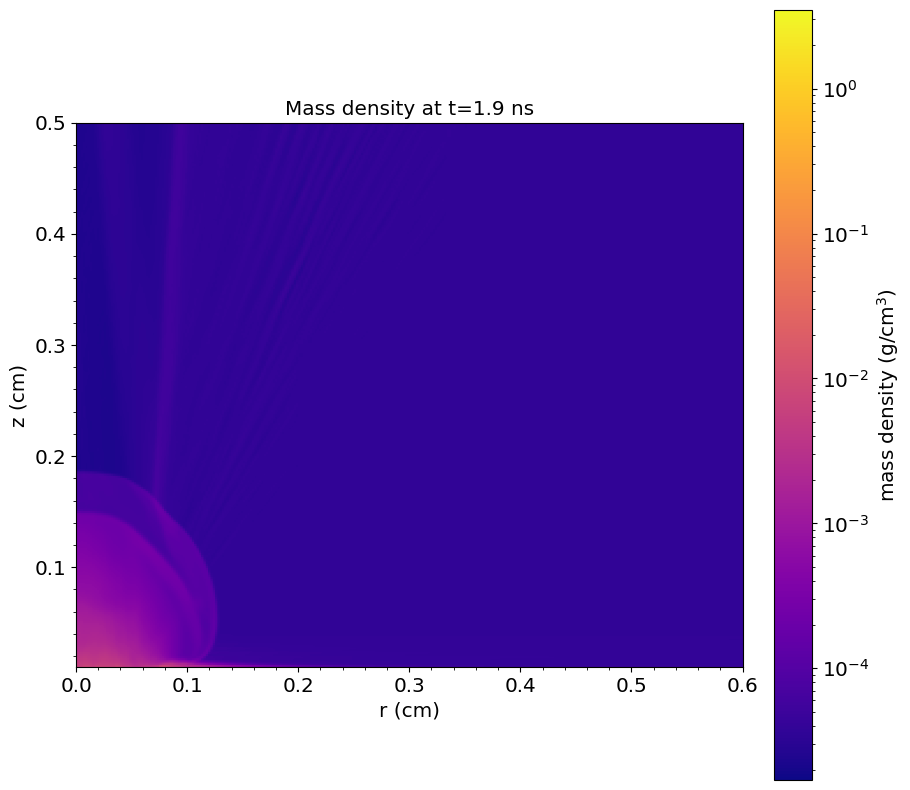

In [13]:
plt.figure(figsize=(10,10))
im = plt.imshow(dens.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04) # fraction and pad are for sizing the colorbar
cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.minorticks_on()
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Mass density at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

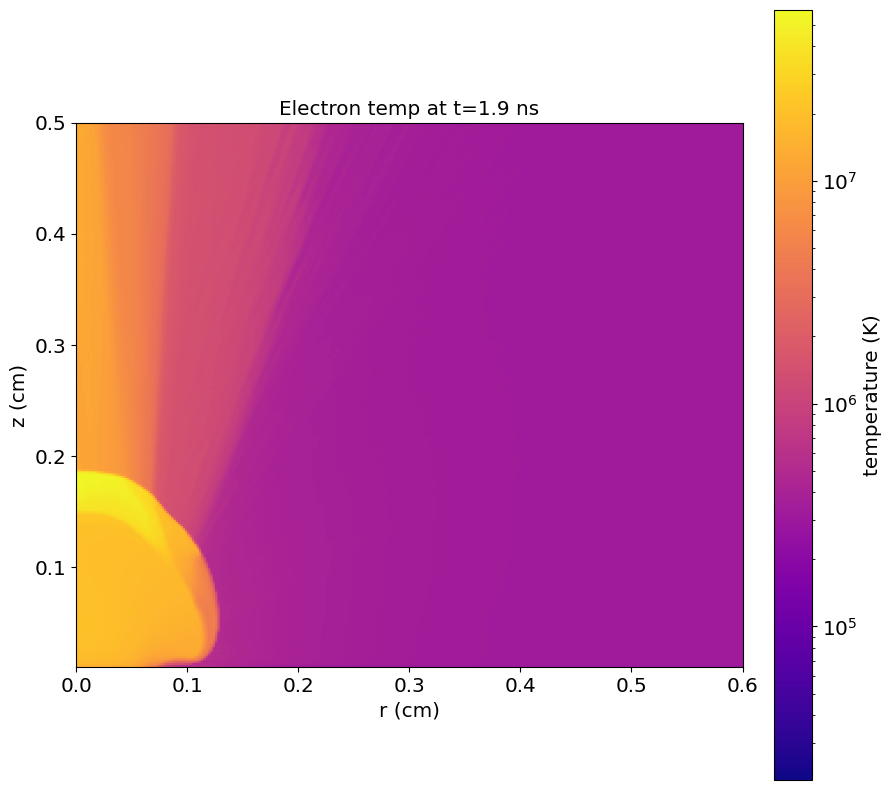

In [14]:
plt.figure(figsize=(10,10))
im = plt.imshow(tele.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04)
cbar.set_label('temperature (K)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Electron temp at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

yt : [INFO     ] 2024-09-25 15:35:43,493 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-25 15:35:43,494 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-25 15:35:43,495 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-09-25 15:35:43,495 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-09-25 15:35:43,495 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800



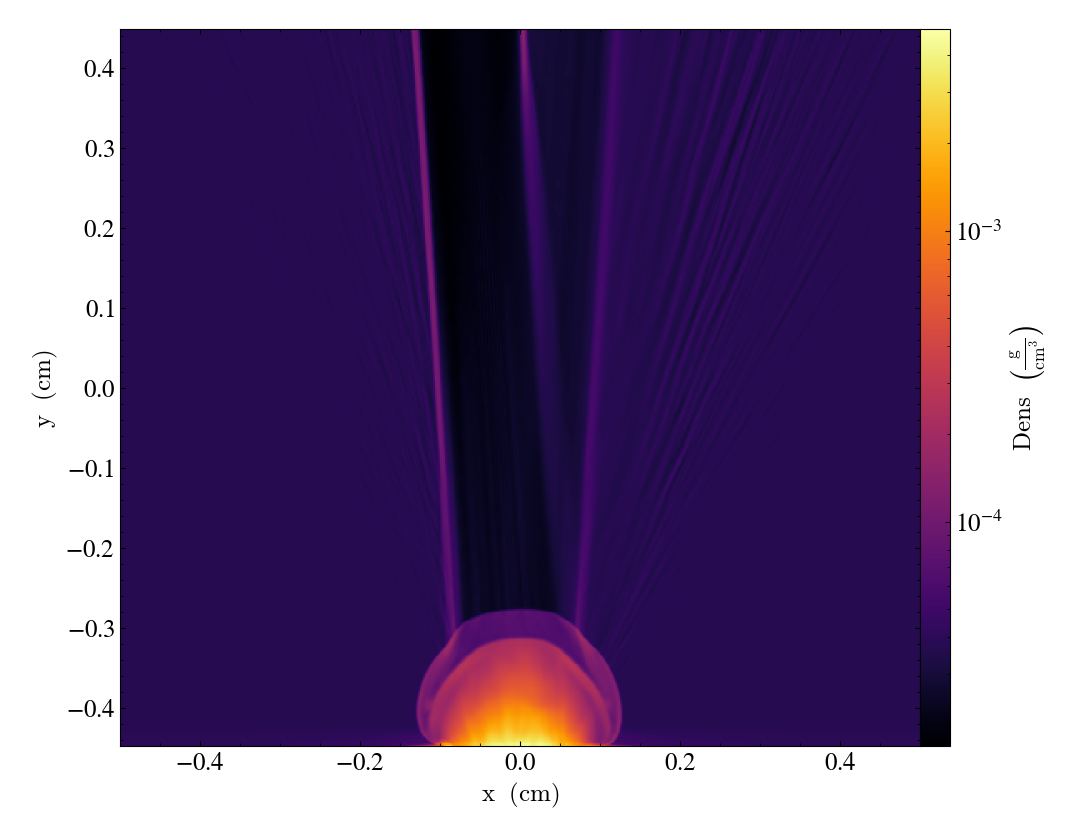

In [22]:
# you can get a very rough slice plot using the native yt plotter

slc = yt.SlicePlot(ds, "z", ("flash","dens")).zoom(1.2).set_cmap("dens","inferno")
slc.set_unit("dens","g/cm**3")
slc.show()